In [1]:
!pip install --upgrade summa
!pip install --upgrade nltk #3.9.1

  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'summa' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'summa'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54441 sha256=4c346584f2eb834cafb630723d7cb5c0c256541dfa026243ccf24465af975a2b
  Stored in directory: /home/jovyan/.cache/pip/wheels/70/26/84/58df5a55ebde6fd802666b6ac0b86909ecd018a2702b89d13c
Successfully built summa
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [nlt

In [1]:
from importlib.metadata import version
import nltk
import torch
import summa
import pandas as pd

print(nltk.__version__)
print(torch.__version__)
print(pd.__version__)
print(version('summa'))

3.9.1
2.7.1+cu118
2.3.0
1.2.0


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
85112,Hong Kong parking space sells for over Ã¢ÂÂ¹4...,A 188-square-foot parking space in Hong Kong h...
2064,Over 1.5 crore people take 'Shahi Snan' on day...,To mark the beginning of the Kumbh Mela in Pra...
48325,Anti-trafficking law proposes life term for re...,"India's first law against human trafficking, l..."
7872,Kerala plans 600-km wall with women to prevent...,Kerala minister Thomas Isaac on Sunday announc...
15088,I know you never think: US Prez Trump mocks re...,US President Donald Trump on Monday mocked a r...
43581,May support no-confidence motion against NDA g...,Andhra Pradesh CM and TDP chief Chandrababu Na...
18763,When doc asks you to lose weight: Smriti Irani...,Actress-turned-politician Smriti Irani on Tues...
31601,"Suffered from depression, had suicidal thought...","Zaira Wasim, known for starring in the film 'D..."
86563,Upset 7-Eleven outlet owner opens 6-Twelve acr...,The former owner of a 7-Eleven Boston outlet h...
63933,Kiran Bedi jumps over hospital fence as offici...,Puducherry Lieutenant Governor Kiran Bedi jump...


In [5]:
# Step2. 추상적 요약을 위해 데이터 정제

In [19]:
!pip install lxml

ERROR: Could not find a version that satisfies the requirement parser (from versions: none)
ERROR: No matching distribution found for parser


Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
전체 샘플수 (중복 제거 후) : 98360
전체 샘플수 (NULL 제거 후) : 98360


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


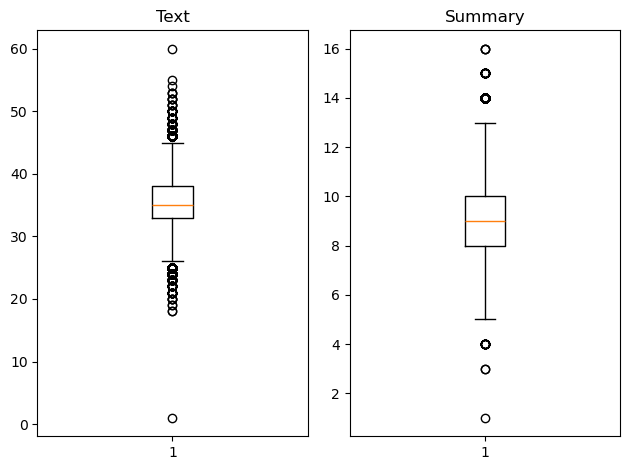

전체 샘플수 (길이 필터링 후) : 27105
훈련 데이터의 개수 : 21684
테스트 데이터의 개수 : 5421


In [16]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from torch.nn.utils.rnn import pad_sequence
import torch
from collections import Counter

# --- 1. 데이터 로드 및 기본 전처리 ---
# 데이터를 불러오고 'Text'와 'Summary' 열만 선택합니다.
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data = data[['text', 'headlines']]
data.columns = ['Text', 'Summary'] # 열 이름 변경

# 중복 샘플과 NULL 값 제거
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
data.drop_duplicates(subset=['Text'], inplace=True)
print('전체 샘플수 (중복 제거 후) :', (len(data)))
data.dropna(axis=0, inplace=True)
print('전체 샘플수 (NULL 제거 후) :', (len(data)))


# --- 2. 텍스트 정규화 및 정제 ---
# 정규화 사전 (축약어 처리)
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

# NLTK 불용어 로드
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, "lxml").text
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    sentence = re.sub('"','', sentence)
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\b","", sentence)
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    sentence = re.sub('[m]{2,}', 'mm', sentence)
    
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

# Text 열은 불용어 제거, Summary 열은 불용어 미제거
data['Text'] = data['Text'].apply(lambda x: preprocess_sentence(str(x)))
data['Summary'] = data['Summary'].apply(lambda x: preprocess_sentence(str(x), False))

# 빈 값을 Null로 변환 후 제거
data.replace('', np.nan, inplace=True)
data.dropna(axis=0, inplace=True)


# --- 3. 샘플 길이 분석 및 필터링 ---
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

# 길이 분포 시각화
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

# 최대 길이 설정 (분석 결과에 따라 조정 가능)
text_max_len = 50
summary_max_len = 8

# 최대 길이보다 긴 샘플 필터링
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 (길이 필터링 후) :', (len(data)))


# --- 4. 디코더 입출력 생성 및 데이터 분할 ---
# 시작 토큰(sostoken)과 종료 토큰(eostoken) 추가
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')

# Numpy 배열로 변환
encoder_input = np.array(data['Text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

# 데이터 셔플
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 8:2 비율로 훈련 데이터와 테스트 데이터 분리
n_of_val = int(len(encoder_input)*0.2)
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))


# --- 5. 정수 인코딩 및 패딩 ---
# 소스(Text) 데이터 단어 집합 생성
src_vocab_size = 8000
def build_limited_vocab(texts, vocab_size):
    vocab = {"<PAD>": 0, "<UNK>": 1}
    word_counter = Counter()
    for text in texts:
        word_counter.update(text.split())
    for word, _ in word_counter.most_common(vocab_size - 2):
        vocab[word] = len(vocab)
    return vocab

src_vocab = build_limited_vocab(encoder_input_train, src_vocab_size)

# 텍스트를 정수 시퀀스로 변환하는 함수
def text_to_sequence(texts, vocab):
    sequences = []
    for text in texts:
        sequence = [vocab.get(word, vocab["<UNK>"]) for word in text.split()]
        sequences.append(sequence)
    return sequences

encoder_input_train_seq = text_to_sequence(encoder_input_train, src_vocab)
encoder_input_test_seq = text_to_sequence(encoder_input_test, src_vocab)

# 타겟(Summary) 데이터 단어 집합 생성
tar_vocab_size = 5000
tar_vocab = build_limited_vocab(np.concatenate([decoder_input_train, decoder_target_train]), tar_vocab_size)
tar_word_to_index = tar_vocab
tar_index_to_word = {idx: word for word, idx in tar_vocab.items()}

decoder_input_train_seq = text_to_sequence(decoder_input_train, tar_vocab)
decoder_target_train_seq = text_to_sequence(decoder_target_train, tar_vocab)
decoder_input_test_seq = text_to_sequence(decoder_input_test, tar_vocab)
decoder_target_test_seq = text_to_sequence(decoder_target_test, tar_vocab)

# 패딩 처리 함수
def pad_sequences_pytorch(sequences, maxlen, padding_value=0):
    tensors = [torch.tensor(seq, dtype=torch.long) for seq in sequences]
    padded_seqs = pad_sequence(tensors, batch_first=True, padding_value=padding_value)
    # maxlen보다 길면 자르고, 짧으면 0으로 채워진 상태
    if padded_seqs.shape[1] > maxlen:
        return padded_seqs[:, :maxlen]
    return padded_seqs

encoder_input_train = pad_sequences_pytorch(encoder_input_train_seq, maxlen=text_max_len)
encoder_input_test = pad_sequences_pytorch(encoder_input_test_seq, maxlen=text_max_len)
decoder_input_train = pad_sequences_pytorch(decoder_input_train_seq, maxlen=summary_max_len)
decoder_target_train = pad_sequences_pytorch(decoder_target_train_seq, maxlen=summary_max_len)
decoder_input_test = pad_sequences_pytorch(decoder_input_test_seq, maxlen=summary_max_len)
decoder_target_test = pad_sequences_pytorch(decoder_target_test_seq, maxlen=summary_max_len)

In [17]:
# Step3. 어텐션 메커니즘을 사용한 seq2seq 모델 설계

In [18]:
import torch.nn as nn
import torch.nn.functional as F

# --- 하이퍼파라미터 정의 ---
embedding_dim = 128
hidden_size = 256
num_layers = 3  # LSTM 레이어의 수
dropout_p = 0.4 # 드롭아웃 확률

# --- 1.1. 인코더 (Encoder) 정의 ---
# 입력 문장을 읽어 하나의 컨텍스트 벡터(Context Vector)로 압축합니다.
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers,
            dropout=dropout, batch_first=True
        )

    def forward(self, x):
        # x: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        output, (hidden, cell) = self.lstm(embedded)
        # output: (batch_size, seq_len, hidden_size)
        # hidden, cell: (num_layers, batch_size, hidden_size)
        return output, hidden, cell

# --- 1.2. 디코더 (Decoder) 정의 ---
# 컨텍스트 벡터를 받아 요약 문장을 생성합니다.
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers,
            dropout=dropout, batch_first=True
        )

    def forward(self, x, hidden, cell):
        # x: (batch_size, 1) - 한 번에 하나의 단어만 입력받음
        embedded = self.embedding(x) # (batch_size, 1, embedding_dim)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        # output: (batch_size, 1, hidden_size)
        return output, hidden, cell

# --- 1.3. 어텐션 (Attention) 메커니즘 정의 ---
# 디코더가 예측할 때 인코더의 모든 출력(단어) 중 어떤 단어에 집중할지 결정합니다.
class Attention_dot(nn.Module):
    def __init__(self, hidden_size):
        super(Attention_dot, self).__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, decoder_output, encoder_outputs):
        # decoder_output: (batch_size, 1, hidden_size)
        # encoder_outputs: (batch_size, seq_len, hidden_size)
        attn_weights = torch.bmm(decoder_output, encoder_outputs.transpose(1, 2))
        attn_weights = F.softmax(attn_weights, dim=-1) # (batch_size, 1, seq_len)
        attn_out = torch.bmm(attn_weights, encoder_outputs) # (batch_size, 1, hidden_size)
        return attn_out

# --- 1.4. Seq2Seq 모델 결합 ---
# 인코더, 디코더, 어텐션을 하나로 묶어 최종 모델을 완성합니다.
class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder, vocab_size, hidden_size):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.attention = Attention_dot(hidden_size)
        self.concat = nn.Linear(hidden_size * 2, hidden_size) # 어텐션 결과를 결합하기 위한 레이어
        self.output_layer = nn.Linear(hidden_size, vocab_size) # 최종 단어 예측을 위한 출력 레이어

    def forward(self, encoder_input, decoder_input):
        encoder_outputs, hidden, cell = self.encoder(encoder_input)
        
        # 학습 시에는 teacher forcing을 위해 전체 요약 문장을 한 번에 처리
        decoder_outputs, _, _ = self.decoder(decoder_input, hidden, cell)

        # 어텐션 적용
        attn_out = self.attention(decoder_outputs, encoder_outputs)
        
        # 어텐션 결과와 디코더 출력을 연결 후 tanh 활성화 함수 적용
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))
        
        # 최종 출력
        output = self.output_layer(decoder_concat_output)
        return output

print("모델 아키텍처 정의 완료.")

모델 아키텍처 정의 완료.


In [19]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# --- 2.1. 모델 인스턴스화 ---
encoder = Encoder(src_vocab_size, embedding_dim, hidden_size, num_layers, dropout_p)
decoder = Decoder(tar_vocab_size, embedding_dim, hidden_size, num_layers, dropout_p)
model = Seq2SeqWithAttention(encoder, decoder, tar_vocab_size, hidden_size)

# --- 2.2. 장치 설정 및 모델 이동 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# --- 2.3. 학습 관련 하이퍼파라미터 ---
batch_size = 256
epochs = 50
learning_rate = 0.001
patience = 2  # 조기 종료(Early Stopping)를 위한 patience 값

# --- 2.4. 손실 함수 및 옵티마이저 ---
# 패딩 토큰(인덱스 0)은 손실 계산에서 무시
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# --- 2.5. PyTorch DataLoader 설정 ---
# 전처리된 데이터를 TensorDataset으로 묶어줍니다.
train_dataset = TensorDataset(encoder_input_train, decoder_input_train, decoder_target_train)
test_dataset = TensorDataset(encoder_input_test, decoder_input_test, decoder_target_test)

# DataLoader를 통해 배치 단위로 데이터를 공급합니다.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("학습 환경 설정 완료.")

Using device: cuda
학습 환경 설정 완료.


In [20]:
%%time
# 위에서 정의한 학습 루프 함수
train_losses = []
val_losses = []

def train_model(model, train_loader, test_loader, criterion, optimizer, epochs, patience):
    model.train()
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        total_loss = 0
        # 훈련 시작
        for encoder_input, decoder_input, target in train_loader:
            optimizer.zero_grad()
            encoder_input = encoder_input.to(device).long()
            decoder_input = decoder_input.to(device).long()
            target = target.to(device).long()
            
            output = model(encoder_input, decoder_input)
            output = output.view(-1, output.shape[-1])
            target = target.view(-1)
            
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 검증 시작
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for encoder_input, decoder_input, target in test_loader:
                encoder_input = encoder_input.to(device).long()
                decoder_input = decoder_input.to(device).long()
                target = target.to(device).long()
                
                output = model(encoder_input, decoder_input)
                output = output.view(-1, output.shape[-1])
                target = target.view(-1)
                loss = criterion(output, target)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # 조기 종료 조건 확인
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
            
        model.train() # 다음 에폭을 위해 다시 훈련 모드로 전환

# 학습 실행
# 주의: 이 과정은 GPU 환경에서도 수십 분 이상 소요될 수 있습니다.
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=epochs, patience=patience)

Epoch 1/50 | Train Loss: 6.8156 | Val Loss: 6.3780
Epoch 2/50 | Train Loss: 6.5088 | Val Loss: 6.3048
Epoch 3/50 | Train Loss: 6.4421 | Val Loss: 6.2912
Epoch 4/50 | Train Loss: 6.3566 | Val Loss: 6.1499
Epoch 5/50 | Train Loss: 6.1980 | Val Loss: 6.0078
Epoch 6/50 | Train Loss: 6.0177 | Val Loss: 5.8543
Epoch 7/50 | Train Loss: 5.8431 | Val Loss: 5.7306
Epoch 8/50 | Train Loss: 5.6676 | Val Loss: 5.6129
Epoch 9/50 | Train Loss: 5.4964 | Val Loss: 5.5114
Epoch 10/50 | Train Loss: 5.3391 | Val Loss: 5.4404
Epoch 11/50 | Train Loss: 5.1815 | Val Loss: 5.3594
Epoch 12/50 | Train Loss: 5.0243 | Val Loss: 5.2927
Epoch 13/50 | Train Loss: 4.8726 | Val Loss: 5.2408
Epoch 14/50 | Train Loss: 4.7285 | Val Loss: 5.1946
Epoch 15/50 | Train Loss: 4.5852 | Val Loss: 5.1777
Epoch 16/50 | Train Loss: 4.4574 | Val Loss: 5.1560
Epoch 17/50 | Train Loss: 4.3265 | Val Loss: 5.1411
Epoch 18/50 | Train Loss: 4.1943 | Val Loss: 5.1348
Epoch 19/50 | Train Loss: 4.0768 | Val Loss: 5.1519
Epoch 20/50 | Train L

In [21]:
# Step4. 실제 결과와 요약문 비교

In [22]:
# --- 1.1. 정수 -> 단어 변환을 위한 딕셔너리 준비 ---
# Step 2에서 생성한 단어 집합(vocab)을 사용합니다.
src_index_to_word = {idx: word for word, idx in src_vocab.items()}
tar_index_to_word = {idx: word for word, idx in tar_vocab.items()}

# --- 1.2. 정수 시퀀스를 텍스트로 변환하는 헬퍼 함수 ---
# 원문(Text) 복원
def seq2text(input_seq):
    # PyTorch 텐서를 순회하며 패딩(0)을 제외하고 단어로 변환합니다.
    return ' '.join(src_index_to_word.get(i.item(), "<UNK>") for i in input_seq if i.item() != 0)

# 실제 요약문(Summary) 복원
def seq2summary(input_seq):
    # 패딩(0)과 시작/종료 토큰을 제외하고 단어로 변환합니다.
    sostoken_index = tar_word_to_index.get('sostoken', -1)
    eostoken_index = tar_word_to_index.get('eostoken', -1)
    return ' '.join(tar_index_to_word.get(i.item(), "<UNK>") for i in input_seq if i.item() not in [0, sostoken_index, eostoken_index])


# --- 1.3. 추론(Inference) 함수 정의 ---
# 학습된 모델로 새로운 요약문을 생성하는 핵심 함수입니다.
def decode_sequence(input_seq, model, tar_word_to_index, tar_index_to_word, max_len_summary, device):
    # 모델을 평가 모드로 설정
    model.eval()

    # 입력 시퀀스를 텐서로 변환하고 배치 차원을 추가
    input_seq = input_seq.unsqueeze(0).to(device)
    
    with torch.no_grad():
        # 1. 인코더 실행
        encoder_outputs, hidden, cell = model.encoder(input_seq)

    # 2. 디코더의 첫 입력으로 <SOS> 토큰 설정
    decoder_input = torch.zeros((1, 1), dtype=torch.long, device=device)
    decoder_input[0, 0] = tar_word_to_index.get('sostoken', 0)
    
    stop_condition = False
    decoded_sentence = []

    # 3. 요약문 생성 루프
    while not stop_condition:
        with torch.no_grad():
            # 이전 스텝의 hidden/cell state를 사용하여 디코더 출력 계산
            decoder_outputs, hidden, cell = model.decoder(decoder_input, hidden, cell)

            # 어텐션 적용
            attn_out = model.attention(decoder_outputs, encoder_outputs)
            
            # 어텐션 결과와 디코더 출력 결합
            concat_output = torch.tanh(model.concat(torch.cat((decoder_outputs, attn_out), dim=-1)))
            
            # 최종 단어 예측
            final_output = model.output_layer(concat_output)

        # 가장 확률이 높은 단어의 인덱스 선택
        sampled_token_index = torch.argmax(final_output[0, -1, :]).item()
        sampled_token = tar_index_to_word.get(sampled_token_index, "<UNK>")
        
        # 4. 종료 조건 확인
        if sampled_token == 'eostoken' or len(decoded_sentence) >= (max_len_summary - 1):
            stop_condition = True
        else:
            decoded_sentence.append(sampled_token)

        # 5. 다음 스텝의 입력으로 현재 예측된 단어 사용
        decoder_input = torch.zeros((1, 1), dtype=torch.long, device=device)
        decoder_input[0, 0] = sampled_token_index

    return ' '.join(decoded_sentence)

print("추론 함수 정의 완료.")

추론 함수 정의 완료.


In [23]:
# --- 테스트 데이터셋의 일부 샘플에 대한 결과 비교 ---
print("\n--- 실제 요약 vs. 예측 요약 비교 ---")

for i in range(20): # 20개의 샘플에 대해 비교
    input_seq = encoder_input_test[i]
    actual_summary_seq = decoder_target_test[i] # eostoken이 포함된 버전
    
    # 예측 요약 생성
    predicted_summary = decode_sequence(
        input_seq, 
        model, 
        tar_word_to_index, 
        tar_index_to_word, 
        summary_max_len, 
        device
    )
    
    print(f"\n--- Sample {i+1} ---")
    print("원문      :", seq2text(input_seq))
    print("실제 요약  :", seq2summary(actual_summary_seq))
    print("예측 요약  :", predicted_summary)


--- 실제 요약 vs. 예측 요약 비교 ---

--- Sample 1 ---
원문      : order provide access information commonly searched <UNK> google rolled new feature called <UNK> search india example user searches <UNK> like <UNK> pain search app show list related conditions individual <UNK> like <UNK> show users <UNK> <UNK> along self treatment options
실제 요약  : google rolls out <UNK> search feature in india
예측 요약  : air india <UNK> <UNK> to <UNK> <UNK>

--- Sample 2 ---
원문      : <UNK> world cricket committee backed discussions <UNK> england wales cricket club start design project manufacturers develop head protection bowlers committee included former indian skipper sourav ganguly former australian captain <UNK> <UNK> viewed footage recent accidents involving bowlers
실제 요약  : world cricket body backs <UNK> <UNK> for <UNK>
예측 요약  : world cup team <UNK> <UNK> to <UNK>

--- Sample 3 ---
원문      : traders body <UNK> india traders threatened launch nationwide agitation government <UNK> billion flipkart walmart deal 

In [24]:
# Step5. Summa 를 이용한 추출적 요약

In [25]:
!pip install summa
import requests
from summa.summarizer import summarize

print("Summa 라이브러리 준비 완료.")

Summa 라이브러리 준비 완료.


In [26]:
# 요약할 텍스트 데이터의 URL
url = "https://raw.githubusercontent.com/modulabs/Aiffel_Resources/main/matrix_synopsis.txt"

# requests를 사용하여 텍스트 데이터 가져오기
try:
    text = requests.get(url, timeout=10).text
    print("--- 원문 텍스트 일부 ---")
    print(text[:1000]) # 원문의 앞 1000자만 출력하여 확인
except requests.exceptions.RequestException as e:
    print(f"텍스트를 불러오는 데 실패했습니다: {e}")
    text = ""

--- 원문 텍스트 일부 ---
In 1999, in an unnamed city, Computer programmer Thomas Anderson (Keanu Reeves) is secretly a hacker known as "Neo". He is restless, eager and driven to learn the meaning of cryptic references to the "Matrix" appearing on his computer. A woman named Trinity is observing Neo, and she does so knowing that Morpheus believes that Neo is "the One".

During one of her forays, Trinity is tracked down by the local police to her hotel room. Outside the hotel a car drives up and three agents appear in neatly pressed black suits. They are Agent Smith (Hugo Weaving), Agent Brown (Paul Goddard), and Agent Jones (Robert Taylor). Trinity calls Morpheus and says that her line was tracked and Morpheus orders her to find another exit. Trinity easily defeats the six policemen sent to apprehend her, using fighting and evasion techniques that seem to defy gravity.

A fierce rooftop chase ensues with Trinity and an Agent leaping impossibly from one building to the next, astonishing the pol

In [27]:
if text:
    print("\n--- 원문 길이의 5%로 추출적 요약 ---")
    summary_ratio = summarize(text, ratio=0.05)
    print(summary_ratio)


--- 원문 길이의 5%로 추출적 요약 ---
The Agents interrogate Neo about Morpheus, but he refuses to cooperate.
Trinity and her allies bring Neo to Morpheus, their leader.
"This," he says, showing an image of a modern city, "is the world that you know." A thing that really exists "only as part of a neural, interactive simulation that we call the Matrix." Morpheus then shows Neo the world as it truly exists today, a scarred, desolate emptiness with charred, abandoned buildings, black earth, and a shrouded sky.
Morpheus liberated Neo because he believes him to be "the One", a prophesied figure destined to dismantle the Matrix and liberate humanity by ending the war with the machines.
Morpheus and Neo are walking down a standard city street in what appears to be the Matrix.
Morpheus and Trinity use a telephone to exit the Matrix, but Neo is ambushed by Agent Smith.
Neo revives with new power to perceive and control the Matrix, and effortlessly destroys Agent Smith, before returning to the real world i

In [28]:
if text:
    print("\n--- 50단어 내외로 추출적 요약 ---")
    summary_words = summarize(text, words=50)
    print(summary_words)


--- 50단어 내외로 추출적 요약 ---
Morpheus and Neo are walking down a standard city street in what appears to be the Matrix.
Morpheus and Trinity use a telephone to exit the Matrix, but Neo is ambushed by Agent Smith.


In [29]:
if text:
    print("\n--- 문장 리스트 형태로 요약 결과 받기 ---")
    summary_sentences = summarize(text, ratio=0.05, split=True)
    
    for i, sentence in enumerate(summary_sentences):
        print(f"[{i+1}] {sentence}")


--- 문장 리스트 형태로 요약 결과 받기 ---
[1] The Agents interrogate Neo about Morpheus, but he refuses to cooperate.
[2] Trinity and her allies bring Neo to Morpheus, their leader.
[3] "This," he says, showing an image of a modern city, "is the world that you know." A thing that really exists "only as part of a neural, interactive simulation that we call the Matrix." Morpheus then shows Neo the world as it truly exists today, a scarred, desolate emptiness with charred, abandoned buildings, black earth, and a shrouded sky.
[4] Morpheus liberated Neo because he believes him to be "the One", a prophesied figure destined to dismantle the Matrix and liberate humanity by ending the war with the machines.
[5] Morpheus and Neo are walking down a standard city street in what appears to be the Matrix.
[6] Morpheus and Trinity use a telephone to exit the Matrix, but Neo is ambushed by Agent Smith.
[7] Neo revives with new power to perceive and control the Matrix, and effortlessly destroys Agent Smith, before

In [31]:
# --- Step 6: 최종 비교 및 분석 ---
import pandas as pd

# 1. 비교 분석을 위해 원본 데이터 다시 로드
# (전처리 과정에서 data DataFrame의 원본 Text가 변경되었기 때문)
original_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
original_data = original_data[['text', 'headlines']]
original_data.columns = ['Text', 'Summary']

# Step 2에서와 동일한 전처리 적용 (중복/결측치 제거)
original_data.drop_duplicates(subset=['Text'], inplace=True)
original_data.dropna(axis=0, inplace=True)

# Step 2에서 사용했던 셔플링 인덱스를 원본 데이터에 동일하게 적용하여 순서를 맞춤
original_data_shuffled = original_data.iloc[indices]

# Step 2에서와 동일한 비율로 테스트 데이터셋 분리
original_text_test = np.array(original_data_shuffled['Text'])[-n_of_val:]


# 2. 추상적 요약과 추출적 요약 결과 비교
comparison_data = []
# 비교할 샘플 개수 (너무 많으면 시간이 오래 걸리므로 10개로 제한)
num_samples_to_compare = 10 

print("--- [비교 분석] 추상적 요약 vs. 추출적 요약 ---")

for i in range(num_samples_to_compare):
    # 데이터 준비
    original_text = original_text_test[i] # 전처리 전 원본 텍스트
    preprocessed_text = seq2text(encoder_input_test[i]) # 전처리 후 텍스트
    actual_summary = seq2summary(decoder_target_test[i]) # 실제 요약

    # 추상적 요약 생성
    abstractive_summary = decode_sequence(
        encoder_input_test[i], 
        model, 
        tar_word_to_index, 
        tar_index_to_word, 
        summary_max_len, 
        device
    )

    # 추출적 요약 생성 (단어 20개 기준으로)
    try:
        extractive_summary = summarize(original_text, words=20)
        if not extractive_summary: # 요약 결과가 비어있을 경우
            extractive_summary = "요약 생성 불가 (원문이 너무 짧음)"
    except ValueError:
        extractive_summary = "요약 생성 불가 (에러 발생)"
    
    # 결과 리스트에 추가
    comparison_data.append([
        preprocessed_text,
        actual_summary,
        abstractive_summary,
        extractive_summary
    ])

# 3. Pandas DataFrame을 사용하여 표로 결과 정리 및 출력
comparison_df = pd.DataFrame(
    comparison_data, 
    columns=["원문 (전처리 후)", "실제 요약", "추상적 요약 (모델 생성)", "추출적 요약 (Summa)"]
)

# 보기 좋게 출력하기 위해 Pandas 옵션 설정
pd.set_option('display.max_colwidth', None)
display(comparison_df)

--- [비교 분석] 추상적 요약 vs. 추출적 요약 ---


,원문 (전처리 후),실제 요약,추상적 요약 (모델 생성),추출적 요약 (Summa)
0,order provide access information commonly searched <UNK> google rolled new feature called <UNK> search india example user searches <UNK> like <UNK> pain search app show list related conditions individual <UNK> like <UNK> show users <UNK> <UNK> along self treatment options,google rolls out <UNK> search feature in india,air india <UNK> <UNK> to <UNK> <UNK>,'Black Panther' actor Chadwick Boseman paid tribute to Marvel Comics co-creator Stan Lee with a video where he is seen playing a set of drums.
1,<UNK> world cricket committee backed discussions <UNK> england wales cricket club start design project manufacturers develop head protection bowlers committee included former indian skipper sourav ganguly former australian captain <UNK> <UNK> viewed footage recent accidents involving bowlers,world cricket body backs <UNK> <UNK> for <UNK>,world cup team <UNK> <UNK> to <UNK>,Glucose is used to produce food sweeteners while acetic acid is used to make paint.
2,traders body <UNK> india traders threatened launch nationwide agitation government <UNK> billion flipkart walmart deal <UNK> claims ignoring bring reforms commerce sector encouraged walmart buy flipkart enter trade <UNK> deal increase <UNK> <UNK> commerce spectrum trader body said,<UNK> threatens nationwide <UNK> on flipkart walmart deal,india <UNK> exchange to invest billion in,A Mumbai man allegedly killed his 80-year-old mother by slitting her throat and sat by her body for over seven hours before surrendering to the police.
3,afghanistan cricket board cancelled scheduled series pakistan week announcing following announcement afghanistan fans started <UNK> hashtag slamming board <UNK> series pakistan calling country <UNK> terrorism <UNK> also cited recent kabul blast tweet announcing cancellation series,afghanistan cancels all <UNK> ties with pakistan,afghanistan <UNK> <UNK> <UNK> <UNK> quits,Khurana asked the delivery boy to meet him outside a metro station and then took him to his alleged house.
4,two russians mistakenly reached <UNK> coast mumbai <UNK> trip tuesday according reports russian couple released police identities verified russian embassy police reportedly concerned boat managed <UNK> navy coast guard surveillance,russians reach mumbai coast by mistake,<UNK> <UNK> <UNK> arrested for <UNK> cattle,Party leaders had kept the cut-outs to seek votes in the villages and semi-urban areas.
5,bihar chief minister nitish kumar submitted resignation governor <UNK> nath tripathi wednesday reports said kumar cited crisis ruling congress rjd jd alliance reason behind resignation comes rjd lalu prasad yadav denied reports nitish kumar sought resignation lalu son deputy cm tejashwi yadav,nitish kumar resigns as bihar chief minister,kejriwal slams pm modi for <UNK> <UNK>,The US and China have now slapped tit-for-tat tariffs on a combined $100 billion of products since early July.
6,historic meeting us president donald trump north korean leader kim jong un held june take place <UNK> hotel singapore <UNK> island area around hotel marked special security zone summit first ever sitting us president north korean leader,singapore <UNK> hotel named trump kim summit <UNK>,trump <UNK> <UNK> <UNK> drills after earthquake,Horlicks recently organized India's first-of-its-kind talent mentorship workshop Passion Paathshaala to help kids discover their passions and encourage them to do more.
7,austrian energy drinks firm red bull created billionaires company globally according <UNK> global rich list red bull founder <UNK> <UNK> net worth billion ranked globally rich list <UNK> retailer <UNK> <UNK> thai conglomerate <UNK> <UNK> created billionaires,which company created the most billionaires globally,world largest electric bezos founder <UNK> becomes,"Previously, Facebook had also denied reports that alleged it knew about Russian involvement in the US elections by 2016 itself."
8,early internet <UNK> lawrence <UNK> passed away december age reportedl